# Synchronous States in Homogeneous Populations of LIF Neurons
### NX-465 Mini-project MP2
### Spring semester 2023

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Simulation parameters
tau_m = 10 #ms
v0 = -50.0  #mV
eta = 0 #mV
v_rest = 15 #mV
R = 50 #membrane resistance 50 Ohm
Beta = 1e2 #ms-1

## Exercise 0: Getting Started: non-interacting population

1. Consider N = 100 non-interacting neurons, with initial voltages vi(t = 0) uniformly distributed at random between v0 and η (i.e. vi(0) ∼ U([v0, η])), and submitted to an oscillating external input Iext(t) = I0(1 + sin(ωt)), with I0 = 0.5 mA, ω = 102s−1(= 0.1 ms−1).

    - Compute the membrane potentials vi(t) and firing times of the neurons, for t ≤ Tf = 100 ms.
    
    - Plot the voltage v1(t) of the first neuron, along with the external input RIext(t).

In [5]:
N = 100 #nb neurons
I0 = 0.5 #mA
omega = 0.1 #ms-1
i_ext = lambda t: I0*(1 + np.sin(omega*t))
dt = 1e-2 #ms

In [6]:
Tf = 100 #ms simulation duration
voltage = np.zeros((N, int(Tf / dt)))
firing_times = np.zeros((N, int(Tf / dt)))

# Initialize membrane potentials randomly
voltage[:, 0] = np.random.uniform(v0, eta, size=N)
raster = []

for t in range(1, int(Tf/dt)):
    
    #dv/dt follows the LIF model, dv/dt = delta_voltage
    delta_voltage =  (1/tau_m) * (-(voltage[:, t - 1] - v_rest)+ R*i_ext((t-1)*dt))
    voltage[:, t] = voltage[:, t - 1] + dt * delta_voltage
    idx_reached_threshold = np.where(voltage[:, t] >= eta)[0]
    raster.append(list(idx_reached_threshold)) # list of sublists that contains idx_reached_threshold
    for neuron in idx_reached_threshold:
        if np.random.rand() < dt*Beta: 
            firing_times[neuron][t] = 1
            voltage[neuron, t] = v0 #reset after spike to v0 

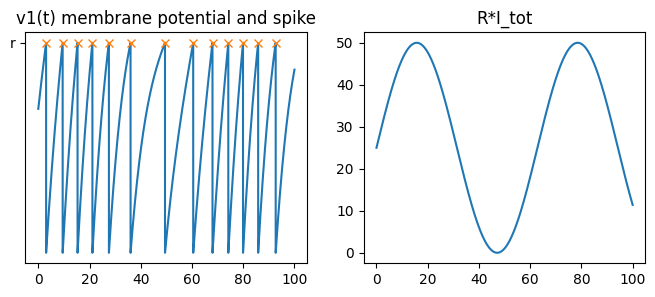

In [12]:
t_space = np.linspace(0, Tf, num = int(Tf/dt))
fig, ax = plt.subplots(1, 2, figsize = (8, 3))
ax[0].plot(t_space, voltage[0,:])
ax[0].set_title("v1(t) membrane potential and spike")
ax[1].plot(t_space, R*i_ext(t_space))
ax[1].set_title("R*I_tot")
# ax[0].plot(t_space, 5*firing_times[0,:])
ax[0].plot(np.where(firing_times[0,:]>0, t_space, np.nan), np.where(firing_times[0,:]>0, 0, np.nan), 'x', 'r')
plt.show()

2. Plot the low-pass filtered activity of the population, using a time bin of τA = 1ms. Make the corresponding raster plot.

How would the system behave as t → ∞? Why?

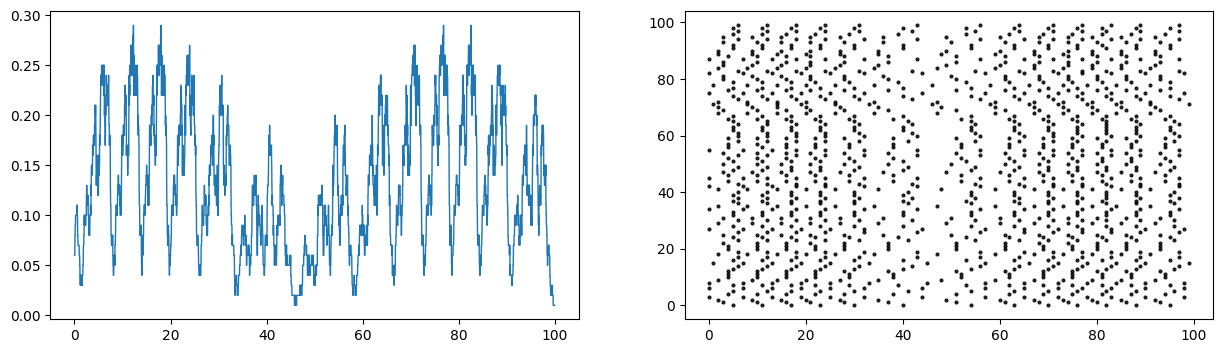

In [50]:
#for the low filtered activity
activity = [(1/dt) * sum(firing_times[:, k])/N for k in range(int(Tf/dt))] #list containing the average activity at each time step k
ta = 100 #size of the bins for convolution (Tf = 100 ms and tau_a = 1ms => ta = 100 bins) (correct ?)
filtered_activity = np.convolve(activity, np.ones(ta), mode='same')/ta

#for the raster plot
raster_ta = [] 
x_coords = []
for idx in range(100):
    neuron_idxs_firing = sum(raster[idx*ta: idx*ta + ta], []) # concatenates into one list the sublist from (idx*ta) to (idx*ta+ta)
    raster_ta.append(neuron_idxs_firing) # list of 100 sublists. 
    for n in neuron_idxs_firing:
        x_coords.append(idx)

#plot
fig, ax = plt.subplots(1,2, figsize = (15, 4))
ax[0].plot(t_space, filtered_activity, linewidth = 1)
ax[1].scatter(x_coords, [item for sublist in raster_ta for item in sublist], c = "k", alpha = 0.8, s= 4)
plt.show()

## Self-interacting population

In [ ]:
delta = 5 #ms 
rise_time = 2 #ms
J = 20 #mV

### Ex 1. Observation of the synchronous state

1. Implement a method that integrates numerically eqs.(4) and (5), given initial conditions vi(0), and ϵA,B(0).

In [ ]:
import pandas as pd

# = np.random.uniform(v0, eta, size=N)
def calculate_potential(T_f, vt0, eA0, eB0, current):
    voltage = np.zeros((N, int(T_f / dt)))
    firing_neurons = [[]]
    kernel = pd.DataFrame({"A": np.zeros(int(T_f/dt)), "B": np.zeros(int(T_f/dt))})

    voltage[:, 0] = vt0
    kernel.loc[0, "A"] = eA0
    kernel.loc[0, "B"] = eB0


    for t in range(1, int(T_f/dt)): 
        
        kernel.loc[t, "B"] = kernel.loc[t-1, "B"] + (1/rise_time) * ((len(firing_neurons[t-1])/N)- dt*kernel.loc[t-1, "B"])
        
        kernel.loc[t, "A"] = kernel.loc[t-1, "A"] + (dt/rise_time) *(kernel.loc[t-1, "B"] - kernel.loc[t-1, "A"])
        
        delta_voltage = (1/tau_m) * (-(voltage[:, t - 1] - v_rest)+ R*0 + tau_m*J*kernel.iloc[t-1-int(delta/dt), 0])
        voltage[:, t] = voltage[:, t - 1] + dt * delta_voltage

        fn_t = list(np.where(voltage[:, t] > eta)[0])
        noiseless_neurons = []
        for neuron in fn_t:
            if np.random.rand() > 1/Beta: 
                noiseless_neurons.append(neuron)
                voltage[neuron, t] = v0 
        firing_neurons.append(noiseless_neurons)
        
    return voltage, firing_neurons

In [ ]:
Tf2 = 600

In [ ]:
v_, firing_neurons = calculate_potential(Tf2, np.random.uniform(v0, eta, size=N), 0, 0, i_ext)

In [ ]:
def plot_raster(fn, ta, T_f):
    
    
    t_space2= np.linspace(0, T_f, num = int(T_f/dt))
    
    activity = [(1/dt) * (len(fn[k])/N) for k in range(int(T_f/dt))]
    filtered_activity = np.convolve(activity, np.ones(ta), mode='same')/ta
    
    raster_neurons = []
    x_coords = []
    for idx in range(T_f):
        neuron_idxs_firing = sum(fn[idx*int((1/dt)): idx*int((1/dt)) + int((1/dt))], [])
        raster_neurons.append(neuron_idxs_firing)
    
        for n in neuron_idxs_firing:
            x_coords.append(idx)
        

    time_frames = [(0, 200), (569, 599)]
    fig, ax = plt.subplots(2,2, figsize = (10, 4))

    xcoords_np = np.array(x_coords)
    raster_neurons_np = np.array([item for sublist in raster_neurons for item in sublist])
    for idx, timef in enumerate(time_frames):
    
        ax[idx, 0].plot(t_space2[int(timef[0]/dt):int(timef[1]/dt)], filtered_activity[
            int(timef[0]/dt):int(timef[1]/dt)])
    
        ax[idx, 1].scatter(xcoords_np[(xcoords_np > timef[0]) & (xcoords_np < timef[1])], raster_neurons_np[
            (xcoords_np > timef[0]) & (xcoords_np < timef[1])], c = "k", alpha = 0.7, s = 3)
    plt.show()
                           
    return x_coords

In [ ]:
x_coords = plot_raster(firing_neurons, ta=50, T_f=Tf2)